## CTC: Cut The Check

An analysis of NBA player salaries based on their statistical performance. (PER Game)

By Daniel Verdear ECE677

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('NBA Player Data 201819.csv')
linReg = LinearRegression()
lasso = Lasso(tol=1)
ridge = Ridge(tol=1)

The first step to completing this analysis is measuring attribute correlation and dimension reduction. This will be accomplished through statistical measurements AND visual plotting. To facilitate this, we must remove all non-numeric attributes.

In [3]:
del df['No.'], df['Date Ht'], df['Birth Date'], df['Unnamed: 0']
del df['Nationality'], df['College']
del df['Rk'], df['Tm'], df['Ht']
del df['Player'], df['Pos']

In [4]:
print(df)

      Wt  Exp  Age   G  GS    MP    FG   FGA    FG%   3P  ...  ORB   DRB  \
0    242    5   24  72  72  32.8  10.0  17.3  0.578  0.7  ...  2.2  10.3   
1    205    8   29  78  78  29.1   6.0  12.4  0.484  1.6  ...  1.1   3.6   
2    229    2   26  64  64  28.6   5.9  11.7  0.505  1.6  ...  1.0   3.5   
3    232    1   23  58   7  17.8   2.5   5.4  0.465  0.9  ...  0.5   2.7   
4    201    5   27  30  16  21.0   2.1   5.5  0.390  1.1  ...  0.2   1.7   
5    224    0   23   8   2  12.3   1.6   4.9  0.333  0.6  ...  1.0   2.8   
6    209    3   26  61   2  20.7   2.7   5.7  0.466  1.1  ...  1.0   3.2   
7    200    5   28  48   0  16.9   2.0   5.0  0.405  0.9  ...  0.1   1.5   
8    203    0   22  27   0  15.2   1.9   4.6  0.403  0.8  ...  0.6   1.8   
9    189    0   20   3   0   2.0   0.7   1.0  0.667  0.3  ...  0.0   0.3   
10   170    4   28  59  19  19.0   2.0   4.4  0.444  0.6  ...  0.7   2.2   
11   250   17   38  30   6  12.0   1.4   3.1  0.447  0.2  ...  0.7   3.8   
12   219    

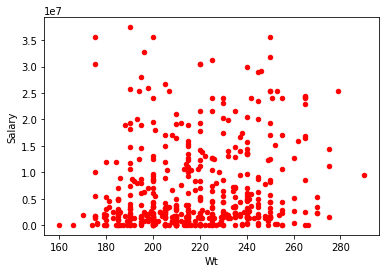

Wt :  0.15960681059680876


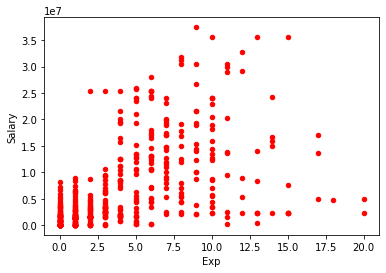

Exp :  0.5366451985790002


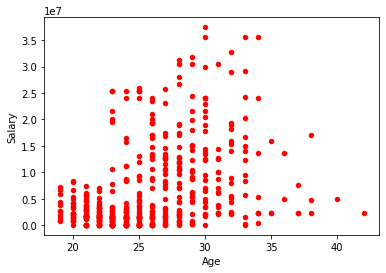

Age :  0.3843316041290845


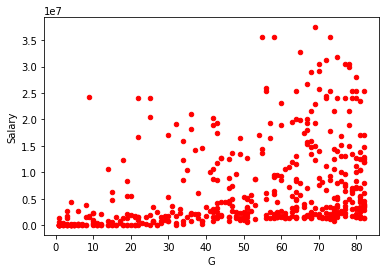

G :  0.3900384534446954


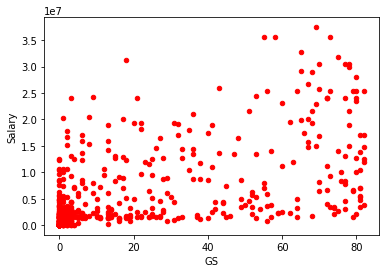

GS :  0.5545505639505214


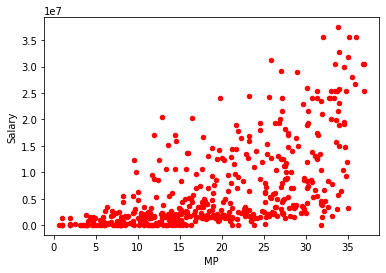

MP :  0.608411493774502


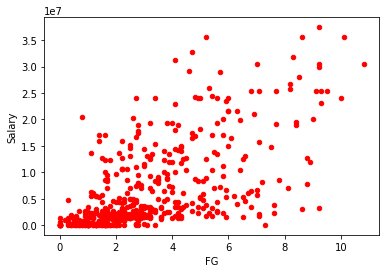

FG :  0.6297577607324482


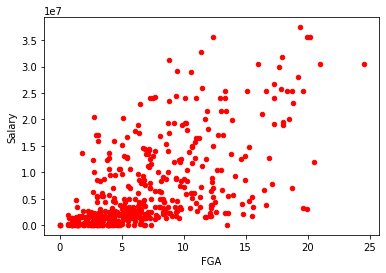

FGA :  0.6199924449570828


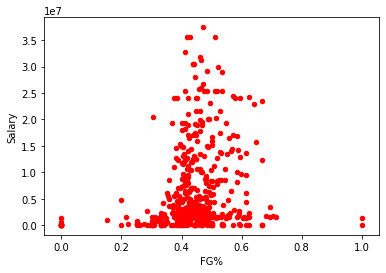

FG% :  0.1951837821626243


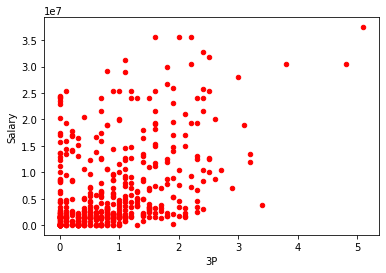

3P :  0.4377613528011507


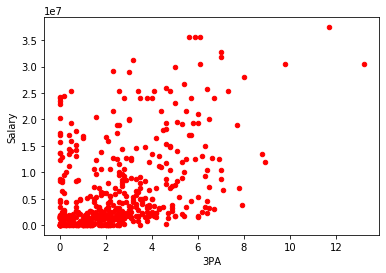

3PA :  0.43821864446040665


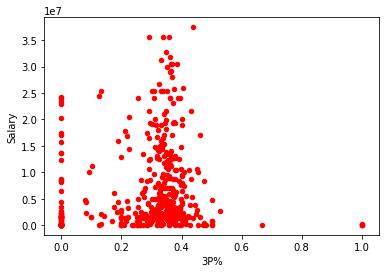

3P% :  0.08691854389579559


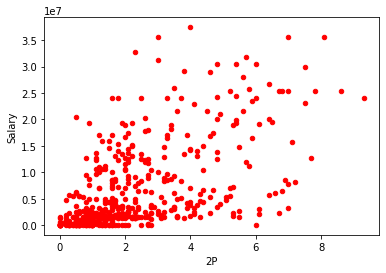

2P :  0.5756836301911249


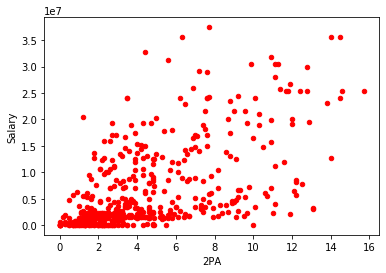

2PA :  0.5813906167137765


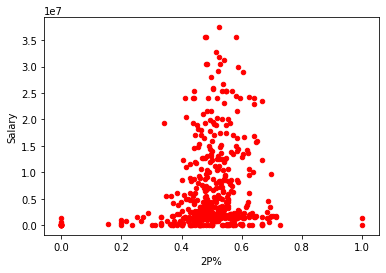

2P% :  0.1756336939910111


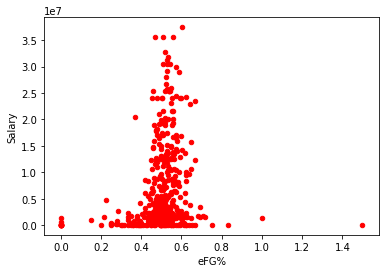

eFG% :  0.17780772519196256


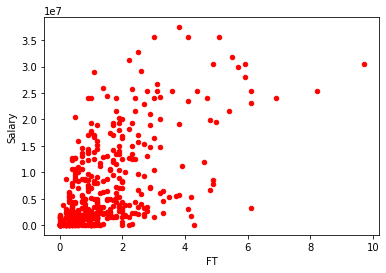

FT :  0.6041576040083655


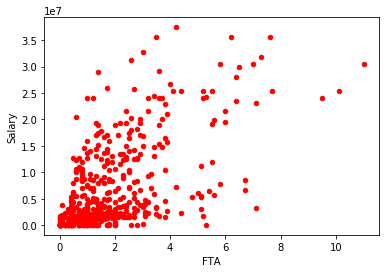

FTA :  0.6070995206897896


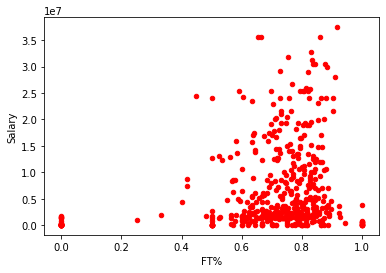

FT% :  0.2230615703954124


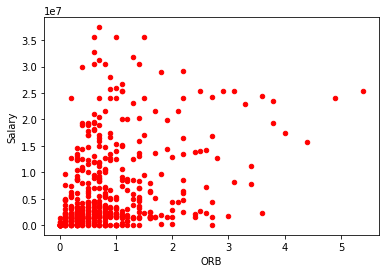

ORB :  0.3488966941726094


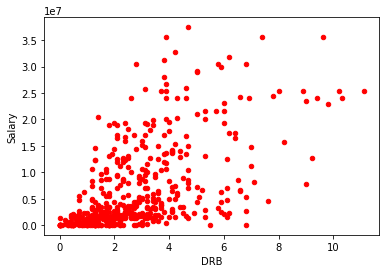

DRB :  0.5767339568893144


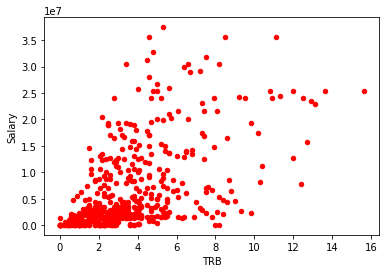

TRB :  0.5403105737540427


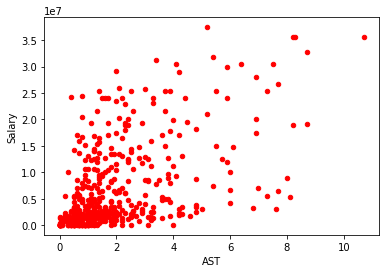

AST :  0.5447328241690035


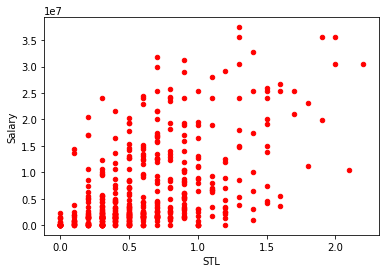

STL :  0.5358214715252724


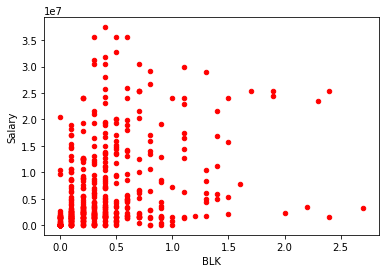

BLK :  0.31811132865644154


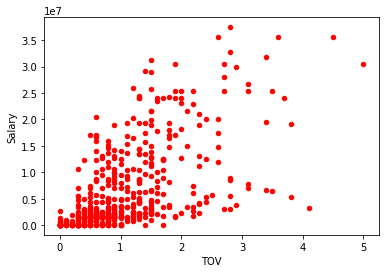

TOV :  0.6073996580494972


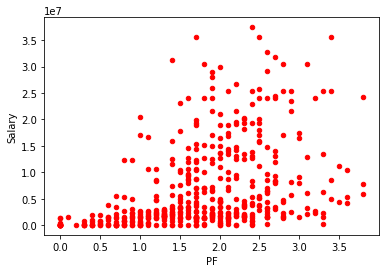

PF :  0.4184565391396885


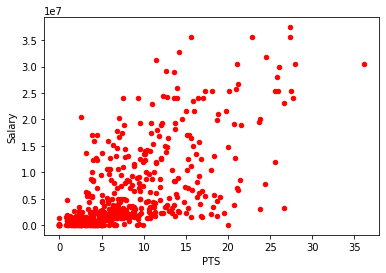

PTS :  0.6417854106448366


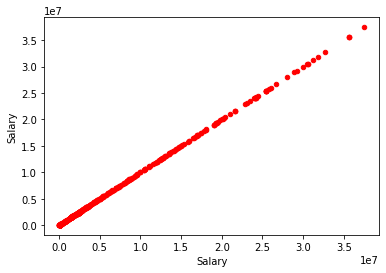

Salary :  1.0


In [5]:
attrs = []
for col in df.columns:
    if (df['Salary'].corr(df[col]) > 0.500):
        attrs.append(col)
    df.plot.scatter(x=col,y='Salary',c='red')
    plt.show()
    print(col,': ',df['Salary'].corr(df[col]))

By taking only attributes with a correlation coefficient above 0.500, we will begin the process of dimension reduction. However, several adjustments will be made based on domain knowledge. These will include removing attributes that are known to be redundant, or including attributes that have correlation coefficients slightly below the threshold that are indicative of overall player performance.

In [6]:
print(attrs)

['Exp', 'GS', 'MP', 'FG', 'FGA', '2P', '2PA', 'FT', 'FTA', 'DRB', 'TRB', 'AST', 'STL', 'TOV', 'PTS', 'Salary']


Salary is the target variable, so it will be removed. Defensive rebounds and Total rebounds are slightly redundant; total rebounds include more impact data (namely defensive+offensive rebounds) and will be kept. 

Though their correlation is slightly below the threshold, 3P and 3PA will be included. With the emphasis on three-point shooting in the NBA, this skill is becoming increasingly valuable. It is not strongly correlated with this data, but we can resonably expect it to correlate with future data.

In [7]:
attrs.remove('Salary')
attrs.remove('DRB')
attrs.append('3PA')
attrs.append('3P')

In [8]:
print(attrs)

['Exp', 'GS', 'MP', 'FG', 'FGA', '2P', '2PA', 'FT', 'FTA', 'TRB', 'AST', 'STL', 'TOV', 'PTS', '3PA', '3P']


We now have a set of informative attributes with which to predict the salary of an NBA player. The final step in data preprocessing is the selection of training and testing sets. This will be done using KFold cross validation from the sklearn library. FIve folds will be used for this analysis. This will give approximately 100 testing samples for each fold.

In [9]:
x = df[attrs]
y = df['Salary']

trainsXY = []
testsXY = []

kf = KFold(n_splits = 5, shuffle = False)
for train_index, test_index in kf.split(x):
    xTrain, xTest = x.iloc[train_index], x.iloc[test_index]
    yTrain, yTest = y.iloc[train_index], y.iloc[test_index]
    trainsXY.append([xTrain,yTrain])
    testsXY.append([xTest,yTest])

In [10]:
for i in range(5):
    tx, ty = trainsXY[i][0],trainsXY[i][1]
    linReg.fit(tx,ty)
    lasso.fit(tx,ty)
    ridge.fit(tx,ty)
    
    ex,ey = testsXY[i][0],testsXY[i][1]
    a = linReg.score(ex,ey)
    b = lasso.score(ex,ey)
    c = ridge.score(ex,ey)
    
    print('Linear: ',a,'\tLasso: ',b,'\tRidge: ',c)

Linear:  0.6296179077418704 	Lasso:  0.5558791859299854 	Ridge:  0.6333064561251387
Linear:  0.4657137164370353 	Lasso:  0.4487936429849134 	Ridge:  0.47003707331225
Linear:  0.5237210134996029 	Lasso:  0.4788268284359886 	Ridge:  0.525676064422061
Linear:  0.7202391109017816 	Lasso:  0.6453733512946764 	Ridge:  0.7203572371178629
Linear:  0.45452620052333065 	Lasso:  0.4272273089439539 	Ridge:  0.45380289594553974


For each iteration of the KFolds cross validation, the Ridge regression model had the best r-squared score. Because the data is represented in 16-dimensional space, it is impossible to plot the regression hyperplane; therefore, we will not be able to verify the r-squared value visually.

Our dataset is relatively small, with only 500 instances, so computational concerns with Ridge compared to Linear regression is not a concern. We will now build the final model that will be used to predict salaries for several impending free agents.

In [11]:
regr = ridge.fit(x,y)
print(ridge.coef_)

[ 720090.72748984   42885.77245672 -203660.60439038 1574184.29843058
  342998.6677878   100546.03969217 -454428.07584338   85802.99054148
 1629660.75350795  706668.10083728  787529.68138466 2271049.86005551
 -449190.51050913 -734959.5867176  -687843.92314207 3255092.7245124 ]


In [12]:
traeYoung2020 = np.array([3,70,35.2,7.3,17.0,4.9,10.5,4.9,5.8,4.2,8.1,1.0,6.2,21.8,6.5,2.4])
regr.predict(traeYoung2020.reshape(1,-1))

array([15168458.08929779])

In [13]:
lukaDoncic2020 = np.array([3,70,33.9,7.7,17.3,4.9,9.8,5.4,7.1,8.2,6.3,1.1,6.0,23.4,7.9,2.8])
regr.predict(lukaDoncic2020.reshape(1,-1))

array([19534532.64625729])

In [14]:
giannisAntetokoumpo2020 = np.array([7,75,36.5,10.1,18.5,7.9,16.1,7.2,9.5,12.9,5.8,1.5,4.2,28.6,0.7,0.3])
regr.predict(giannisAntetokoumpo2020.reshape(1,-1))

array([25431312.67791291])

These predictions are in some cases significantly off what was expected. Giannis Antetokoumpo was the NBA MVP last season, but the algorithm considers him to only be worth $25M. Additionally, it was shown earlier that each attribute kept has a positive correlation with salary; however, some attributes have negative coefficients in our regression model.

By observation, we notice that 2PA and 3PA are significant contributors to negative regression values. However, based on domain knowledge, a player needs to attempt more shots to make more shots. 

In [15]:
x = df[attrs]
del x['3PA'], x['2PA']
y = df['Salary']
trainsXY = []
testsXY = []

kf = KFold(n_splits = 5, shuffle = False)
for train_index, test_index in kf.split(x):
    xTrain, xTest = x.iloc[train_index], x.iloc[test_index]
    yTrain, yTest = y.iloc[train_index], y.iloc[test_index]
    trainsXY.append([xTrain,yTrain])
    testsXY.append([xTest,yTest])

In [16]:
for i in range(5):
    tx, ty = trainsXY[i][0],trainsXY[i][1]
    linReg.fit(tx,ty)
    lasso.fit(tx,ty)
    ridge.fit(tx,ty)
    
    ex,ey = testsXY[i][0],testsXY[i][1]
    a = linReg.score(ex,ey)
    b = lasso.score(ex,ey)
    c = ridge.score(ex,ey)
    
    print('Linear: ',a,'\tLasso: ',b,'\tRidge: ',c)

Linear:  0.6323450514617412 	Lasso:  0.5572978328907945 	Ridge:  0.6352742942933614
Linear:  0.468634119792994 	Lasso:  0.4482672392838251 	Ridge:  0.4710674449631927
Linear:  0.5238891425433909 	Lasso:  0.4769768379487397 	Ridge:  0.5255407825950831
Linear:  0.7197527933774945 	Lasso:  0.6447390108811664 	Ridge:  0.7201078240635168
Linear:  0.45480166683730133 	Lasso:  0.42495613819898337 	Ridge:  0.4547283992486441


In [17]:
regr = ridge.fit(x,y)
print(ridge.coef_)

[ 719323.39554051   43141.40374082 -205553.49617614 1613800.12027332
 -188875.28836612  323867.52906161  136664.3256637  1628963.22410175
  706686.65069439  787519.58764421 2271066.5458281  -447020.3539161
 -795975.23577984 3040823.51495422]


In [18]:
trae = np.array([3,70,35.2,7.3,17.0,4.9,4.9,5.8,4.2,8.1,1.0,6.2,21.8,2.4])
regr.predict(trae.reshape(1,-1))

array([15100551.07527189])

In [21]:
#['Exp', 'GS', 'MP', 'FG', 'FGA', '2P', '2PA', 'FT', 'FTA', 'TRB', 'AST', 'STL', 'TOV', 'PTS', '3PA', '3P']

luka = np.array([3,70,33.9,7.7,17.3,4.9,5.4,7.1,8.2,6.3,1.1,6.0,23.4,2.8])
regr.predict(luka.reshape(1,-1))

array([19811103.53518246])

In [19]:
giannis = np.array([7,75,36.5,10.1,18.5,7.9,7.2,9.5,12.9,5.8,1.5,4.2,28.6,0.3])
regr.predict(giannis.reshape(1,-1))

array([24042845.80621198])

These results are generally discouraging, but they lead to some fundamental truths about NBA salary negotiations. They do not occur in a vacuum and are not a highly predictable process.

At their base, salary negotiations are economic transactions that are negotiated between two human parties. Generally, systems based on human behavior are much harder to predict than physical processes. We have shown this through our predictive case studies. Every single statistic kept for analysis has been shown to correlate positively with salary, but the predictive algorithm will repeatedly undervalue players. In reality, an MVP-level player will never be paid less than $30M, so human factors come into play for moving from 24 to 35 million.

Negotiation environments change year by year, as league-wide cap space fluctuates and players gain or lose leverage based on the number of teams willing to pay for their services. To derive the most knowledge, a dataset consisting of statistics and salaries from several years should be used to account for this. The current analysis must be limited to just the 2018-19 season  because publicly available salary information is typically replaced every league year. It is increasingly difficult to find data on non-star players' salaries in preceding years. Such a dataset must be built over time.

However, for the purposes of the regression experiment as presently constructed, we conclude that this problem is too complex for the data available. We advise that teams NOT make contract offers based on this analysis.